In [1]:
import tensorflow as tf
import tensorflow.keras

In [2]:
tensorflow.keras.__version__

'2.5.0'

In [3]:
tf.__version__

'2.5.0'

In [4]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',\
    include_top=False, input_shape=(150,150,3))

58892288/58889256 [==============================] - 5s 0us/step


In [5]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [7]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

with tf.device('/GPU:0'):
    train_features, train_labels = extract_features(train_dir, 2000)
    validation_features, validation_labels = extract_features(validation_dir, 1000)
    test_features, test_labels = extract_features(test_dir, 1000)
    

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [10]:
from tensorflow.keras import models, layers, optimizers

with tf.device('/GPU:0'):
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_dim = 4 * 4 * 512))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',\
        optimizer = optimizers.RMSprop(learning_rate=2e-5),
        metrics=['acc'])

    history = model.fit(
        train_features,
        train_labels,
        epochs=30,
        batch_size=20,
        validation_data=(validation_features, validation_labels)
    )

Epoch 1/30
100/100 [==============================] - 1s 8ms/step - loss: 0.6090 - acc: 0.6725 - val_loss: 0.4360 - val_acc: 0.8330
Epoch 2/30
100/100 [==============================] - 1s 5ms/step - loss: 0.4270 - acc: 0.8090 - val_loss: 0.3578 - val_acc: 0.8600
Epoch 3/30
100/100 [==============================] - 0s 5ms/step - loss: 0.3547 - acc: 0.8495 - val_loss: 0.3162 - val_acc: 0.8800
Epoch 4/30
100/100 [==============================] - 0s 5ms/step - loss: 0.3139 - acc: 0.8610 - val_loss: 0.2966 - val_acc: 0.8770
Epoch 5/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2920 - acc: 0.8815 - val_loss: 0.2794 - val_acc: 0.8880
Epoch 6/30
100/100 [==============================] - 1s 5ms/step - loss: 0.2701 - acc: 0.8890 - val_loss: 0.2711 - val_acc: 0.8920
Epoch 7/30
100/100 [==============================] - 0s 5ms/step - loss: 0.2479 - acc: 0.9050 - val_loss: 0.2597 - val_acc: 0.8970
Epoch 8/30
100/100 [==============================] - 0s 5ms/step - loss: 0.

In [11]:
import matplotlib.pyplot as plt

In [12]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

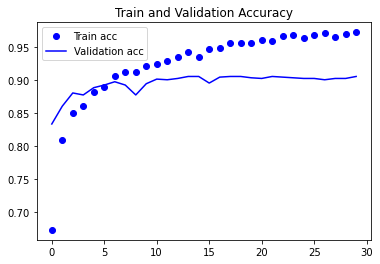

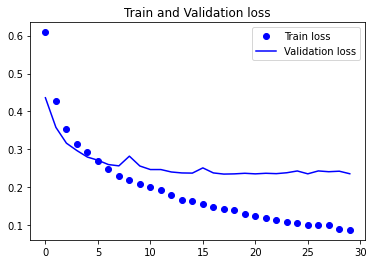

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Train acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Train and Validation loss')
plt.legend()

plt.show()

In [28]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [30]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:',\
    len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 4


In [31]:
conv_base.trainable = False

In [20]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:',\
    len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


In [32]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

model.compile(loss='binary_crossentropy', \
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    metrics=['acc'])

history = model.fit(train_generator, steps_per_epoch=100, epochs=30,\
    validation_data=validation_generator, validation_steps=50, verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 13s - loss: 0.5394 - acc: 0.7490 - val_loss: 0.4168 - val_acc: 0.8480
Epoch 2/30
100/100 - 12s - loss: 0.4168 - acc: 0.8265 - val_loss: 0.3530 - val_acc: 0.8480
Epoch 3/30
100/100 - 11s - loss: 0.3533 - acc: 0.8610 - val_loss: 0.3146 - val_acc: 0.8700
Epoch 4/30
100/100 - 12s - loss: 0.3228 - acc: 0.8680 - val_loss: 0.2887 - val_acc: 0.8880
Epoch 5/30
100/100 - 11s - loss: 0.3160 - acc: 0.8735 - val_loss: 0.2762 - val_acc: 0.8950
Epoch 6/30
100/100 - 11s - loss: 0.2923 - acc: 0.8830 - val_loss: 0.2677 - val_acc: 0.8920
Epoch 7/30
100/100 - 11s - loss: 0.2894 - acc: 0.8845 - val_loss: 0.2594 - val_acc: 0.8890
Epoch 8/30
100/100 - 11s - loss: 0.2742 - acc: 0.8870 - val_loss: 0.2583 - val_acc: 0.8930
Epoch 9/30
100/100 - 11s - loss: 0.2659 - acc: 0.8880 - val_loss: 0.2467 - val_acc: 0.8990
Epoch 10/30
100/100 - 11s - loss: 0.2600 - acc: 0.8905 - val_loss: 0.2456 - val_acc: 0.8960
Epoch

In [33]:
model.save('cats_and_dogs_small_3.h5')

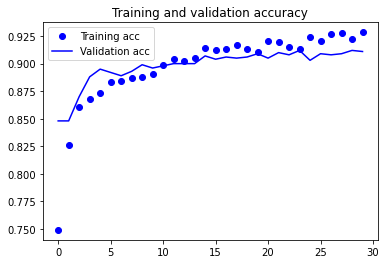

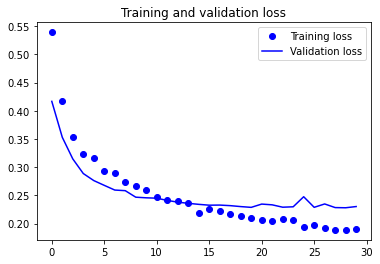

In [34]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [37]:
for layer in conv_base.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [38]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [39]:
model.compile(loss='binary_crossentropy',\
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    metrics=['acc'])

history = model.fit(train_generator, steps_per_epoch=100, \
    epochs=100, validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 24s 226ms/step - loss: 0.1983 - acc: 0.9190 - val_loss: 0.2158 - val_acc: 0.9140
Epoch 2/100
100/100 [==============================] - 25s 249ms/step - loss: 0.1696 - acc: 0.9330 - val_loss: 0.2365 - val_acc: 0.9000
Epoch 3/100
100/100 [==============================] - 11s 110ms/step - loss: 0.1461 - acc: 0.9410 - val_loss: 0.1998 - val_acc: 0.9190
Epoch 4/100
100/100 [==============================] - 18s 184ms/step - loss: 0.1110 - acc: 0.9525 - val_loss: 0.2416 - val_acc: 0.9080
Epoch 5/100
100/100 [==============================] - 12s 118ms/step - loss: 0.0953 - acc: 0.9655 - val_loss: 0.2501 - val_acc: 0.9160
Epoch 6/100
100/100 [==============================] - 11s 113ms/step - loss: 0.1006 - acc: 0.9630 - val_loss: 0.2083 - val_acc: 0.9250
Epoch 7/100
100/100 [==============================] - 12s 121ms/step - loss: 0.0850 - acc: 0.9705 - val_loss: 0.2155 - val_acc: 0.9280
Epoch 8/100
100/100 [===========================

In [40]:
model.save('cats_and_dogs_small_4.h5')

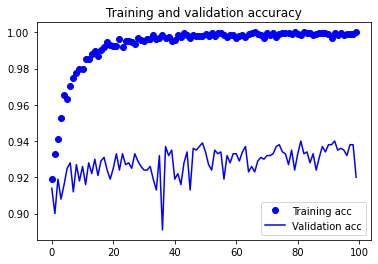

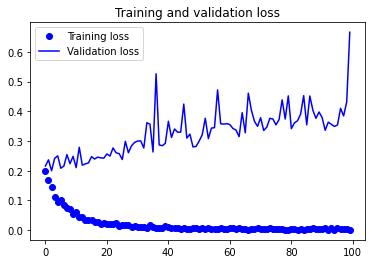

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

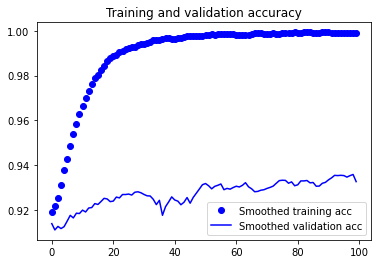

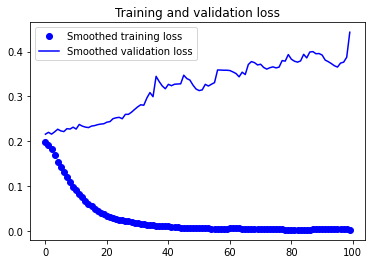

In [42]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [43]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print("test acc :", test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 2s 43ms/step - loss: 0.7136 - acc: 0.9180
test acc : 0.9179999828338623
